In [10]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

%matplotlib inline
sns.set(style='whitegrid')
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Data Import and Creation

In [4]:
def drop_columns(data):
    return data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

data = yf.Ticker('MSFT')
df = drop_columns(data.history(start='2010-01-01'))
df.head()

,Close
Date,
2010-01-04,24.17
2010-01-05,24.18
2010-01-06,24.03
2010-01-07,23.78
2010-01-08,23.94


In [8]:
samples = np.arange(0, len(df), 1)
values = df['Close'].to_numpy()
values.shape, samples.shape

((2704,), (2704,))

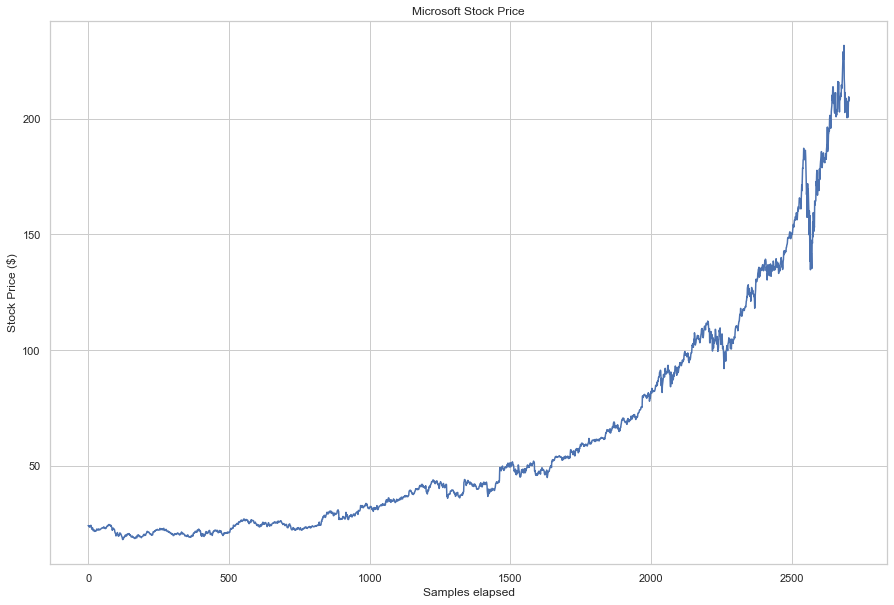

In [11]:
plt.figure(figsize=(15,10))
plt.title('Microsoft Stock Price')
plt.plot(samples, values)
plt.xlabel('Samples elapsed')
plt.ylabel('Stock Price ($)')
plt.show()

## Data Preprocessing

In [13]:
df = pd.DataFrame(dict(price=values), index=samples, columns=['price'])
df.head()

,price
0,24.17
1,24.18
2,24.03
3,23.78
4,23.94


In [17]:
train_size = int(len(df)*0.7)
val_size = int(len(df)*0.2)
test_size = int(len(df)*0.1)

val_set = train_size + val_size
test_size = train_size + val_size + test_size
train, val, test = df.iloc[0:train_size], df.iloc[train_size:val_set], df.iloc[val_set:len(df)]
len(train), len(val), len(test)

(1892, 540, 272)

In [18]:
TIME_STEPS = 10

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i+time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train, train.price, TIME_STEPS)
X_val, y_val = create_dataset(val, val.price, TIME_STEPS)
X_test, y_test = create_dataset(test, test.price, TIME_STEPS)

X_train.shape, y_train.shape

((1882, 10, 1), (1882,))

## Basic Modelling

In [20]:
def generate_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
        tf.keras.layers.Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

model = generate_model()
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    verbose=1,
    shuffle=False
)

Epoch 1/50
118/118 [==============================] - 1s 8ms/step - loss: 445.0974
Epoch 2/50
118/118 [==============================] - 1s 8ms/step - loss: 191.0077
Epoch 3/50
118/118 [==============================] - 1s 7ms/step - loss: 179.5295
Epoch 4/50
118/118 [==============================] - 1s 7ms/step - loss: 177.8637
Epoch 5/50
118/118 [==============================] - 1s 7ms/step - loss: 183.0793
Epoch 6/50
118/118 [==============================] - 1s 7ms/step - loss: 147.7099
Epoch 7/50
118/118 [==============================] - 1s 7ms/step - loss: 144.2868
Epoch 8/50
118/118 [==============================] - 1s 7ms/step - loss: 105.2537
Epoch 9/50
118/118 [==============================] - 1s 7ms/step - loss: 89.0478
Epoch 10/50
118/118 [==============================] - 1s 7ms/step - loss: 71.0596
Epoch 11/50
118/118 [==============================] - 1s 7ms/step - loss: 63.8473
Epoch 12/50
118/118 [==============================] - 1s 7ms/step - loss: 46.6877
Epoch

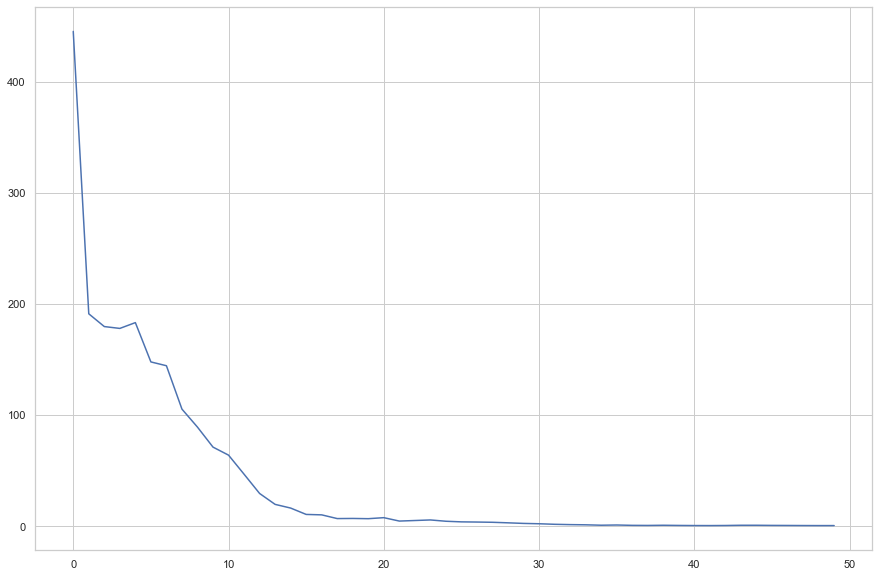

In [21]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'])
plt.show()

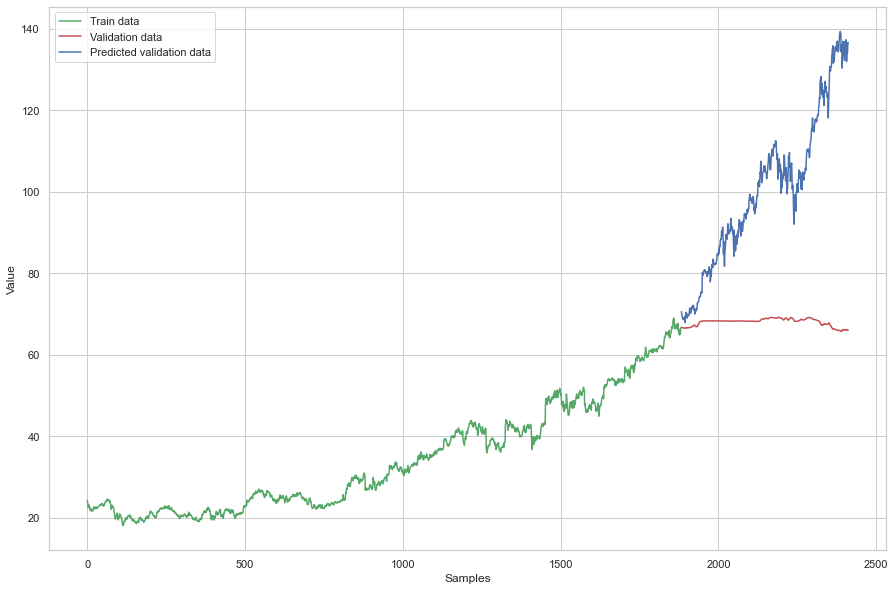

In [22]:
y_pred_val = model.predict(X_val)

plt.figure(figsize=(15,10))
plt.plot(np.arange(0, len(y_train)), y_train, 'g')
plt.plot(np.arange(len(y_train), (len(y_train)+len(y_pred_val))), y_pred_val, 'r')
plt.plot(np.arange(len(y_train), (len(y_train)+len(y_pred_val))), y_val, 'b')
plt.legend(['Train data', 'Predicted validation data', 'Actual validation data'])
plt.xlabel('Samples')
plt.ylabel('Value')
plt.show()